# TinyStories in TransformerLens


## Tiny Stories Model

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig

"""
roneneldan/TinyStories-1M
roneneldan/TinyStories-3M
roneneldan/TinyStories-8M
roneneldan/TinyStories-28M
roneneldan/TinyStories-33M
roneneldan/TinyStories-1Layer-21M
roneneldan/TinyStories-2Layers-33M
roneneldan/TinyStories-Instruct-1M
roneneldan/TinyStories-Instruct-3M
roneneldan/TinyStories-Instruct-8M
roneneldan/TinyStories-Instruct-28M
roneneldan/TinyStories-Instruct-33M
roneneldan/TinyStories-Instuct-1Layer-21M
roneneldan/TinyStories-Instruct-2Layers-33M
"""

current_model = "roneneldan/TinyStories-1Layer-21M"

model = AutoModelForCausalLM.from_pretrained(current_model)
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")
prompt = """One day, Lucy asks Tom: "I am looking for a banana but I can't find it". Tom says: "Don't"""
input_ids = tokenizer.encode(prompt, return_tensors="pt")
output = model.generate(input_ids, max_length = 1000, num_beams=1)
print(output[0])
output_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(output_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([ 3198,  1110,    11, 22162,  7893,  4186,    25,   366,    40,   716,
         2045,   329,   257, 25996,   475,   314,   460,   470,  1064,   340,
         1911,  4186,  1139,    25,   366,  3987,   470,  5490,    11,   314,
          481,  1037,   345,   526,   198,   198, 25596,   948,   290,  4186,
          804,   329,   262, 25996,  1978,    13,  1119,   804,   739,   262,
         7150,   290,  2157,   262, 37413,    13,  1119,  1064,   262, 25996,
          290,  4186,   318,   845,  3772,    13,   198,   198, 11158,    11,
          484,   766,   257,  1263, 25996,  5509,    13,  1119,  1111,  1254,
         6613,   290,  3772,    13,  1119,   910,    25,   366,  1135,   750,
          340,     0,   775,  1043,   262, 25996,  2474,   198,   198,  4863,
          326,  1110,   319,    11, 22162,   290,  4186,   547,   262,  1266,
          286,  2460,    13,  1119,  2826,  1978,   790,  1110,   290,  1464,
         4193,  1123,   584,    13,   198, 50256])
One day, Lucy

## Hooked Transformer

In [2]:
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
model = HookedTransformer.from_pretrained(
    current_model,
    hf_model=model,
    device="cpu",
    fold_ln=False,
    center_writing_weights=False,
    center_unembed=False,
    tokenizer=tokenizer)

Using pad_token, but it is not set yet.


Loaded pretrained model roneneldan/TinyStories-1Layer-21M into HookedTransformer


In [3]:
prompt = """One day, Lucy asks Tom: "I am looking for a banana but I can't find it”. Tom says: "Don't"""
input_ids = tokenizer.encode(prompt, return_tensors="pt")
output = model.generate(input_ids)

  0%|          | 0/10 [00:00<?, ?it/s]

In [4]:
print(output[0])
output_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(output_text)

tensor([ 3198,  1110,    11, 22162,  7893,  4186,    25,   366,    40,   716,
         2045,   329,   257, 25996,   475,   314,   460,   470,  1064,   340,
          447,   251,    13,  4186,  1139,    25,   366,  3987,   470,  5490,
           11,   314,   481,  1037,   345,   526,   198,   198, 25596])
One day, Lucy asks Tom: "I am looking for a banana but I can't find it”. Tom says: "Don't worry, I will help you."

Lu


## Analysis

### Attention Visualisation

In [5]:
tinystories_text   = """One day, Lucy asks Tom: "I am looking for a banana but I can't find it". Tom says: "Don't"""
tinystories_tokens = model.to_tokens(tinystories_text)
tinystories_logits, tinystories_cache = \
    model.run_with_cache(
        tinystories_tokens,
        remove_batch_dim=True)

In [6]:
print("\n".join([k for k in tinystories_cache.keys()]))

hook_embed
hook_pos_embed
blocks.0.hook_resid_pre
blocks.0.ln1.hook_scale
blocks.0.ln1.hook_normalized
blocks.0.attn.hook_q
blocks.0.attn.hook_k
blocks.0.attn.hook_v
blocks.0.attn.hook_attn_scores
blocks.0.attn.hook_pattern
blocks.0.attn.hook_z
blocks.0.hook_attn_out
blocks.0.hook_resid_mid
blocks.0.ln2.hook_scale
blocks.0.ln2.hook_normalized
blocks.0.mlp.hook_pre
blocks.0.mlp.hook_post
blocks.0.hook_mlp_out
blocks.0.hook_resid_post
ln_final.hook_scale
ln_final.hook_normalized


In [7]:
layer_idx = 0

In [8]:
attention_pattern = tinystories_cache["pattern", layer_idx, "attn"]
tinystories_str_tokens = model.to_str_tokens(tinystories_text)

In [9]:
import circuitsvis as cv
print(f"Layer {layer_idx} Head Attention Patterns:")
cv.attention.attention_patterns(
    tokens=tinystories_str_tokens,
    attention=attention_pattern)

Layer 0 Head Attention Patterns:


### Hook: Ablate Head

In [11]:
import transformer_lens.utils as utils

layer_to_ablate = 0
head_index_to_ablate = 8

# We define a head ablation hook
# The type annotations are NOT necessary, they're just a useful guide to the reader
# 
def head_ablation_hook(
    value,
    hook,
):
    print(f"Shape of the value tensor: {value.shape}")
    value[:, :, head_index_to_ablate, :] = 0.
    return value

original_loss = model(tinystories_str_tokens, return_type="loss")
ablated_loss = model.run_with_hooks(
    tinystories_str_tokens, 
    return_type="loss", 
    fwd_hooks=[(
        utils.get_act_name("v", layer_to_ablate), 
        head_ablation_hook
        )]
    )

print(f"Original Loss: {original_loss.item():.3f}")
print(f"Ablated Loss: {ablated_loss.item():.3f}")

# Shape of value tensor (prompt_len?, ?, n_head, head_dim)

Shape of the value tensor: torch.Size([28, 2, 16, 64])
Original Loss: 10.935
Ablated Loss: 9.140


### Detect Attention Heads

In [10]:
from typing import List

detection_threshold = 0.4

def current_attn_detector(cache: ActivationCache) -> List[str]:
    '''
    Returns a list e.g. ["0.2", "1.4", "1.9"] of "layer.head" which you judge to be current-token heads
    '''
    attn_heads = []
    for layer in range(model.cfg.n_layers):
        for head in range(model.cfg.n_heads):
            attention_pattern = cache["pattern", layer][head]
            # take avg of diagonal elements
            score = attention_pattern.diagonal().mean()
            if score > detection_threshold:
                attn_heads.append(f"{layer}.{head}")
    return attn_heads

def prev_attn_detector(cache: ActivationCache) -> List[str]:
    '''
    Returns a list e.g. ["0.2", "1.4", "1.9"] of "layer.head" which you judge to be prev-token heads
    '''
    attn_heads = []
    for layer in range(model.cfg.n_layers):
        for head in range(model.cfg.n_heads):
            attention_pattern = cache["pattern", layer][head]
            # take avg of sub-diagonal elements
            score = attention_pattern.diagonal(-1).mean()
            if score > detection_threshold:
                attn_heads.append(f"{layer}.{head}")
    return attn_heads

def first_attn_detector(cache: ActivationCache) -> List[str]:
    '''
    Returns a list e.g. ["0.2", "1.4", "1.9"] of "layer.head" which you judge to be first-token heads
    '''
    attn_heads = []
    for layer in range(model.cfg.n_layers):
        for head in range(model.cfg.n_heads):
            attention_pattern = cache["pattern", layer][head]
            # take avg of 0th elements
            score = attention_pattern[:, 0].mean()
            if score > detection_threshold:
                attn_heads.append(f"{layer}.{head}")
    return attn_heads

"""
Automated detection matches manual qualitative analysis in README.md
0.3 threshold finds heads which overlap with target behaviour but other behaviour as well
0.4 threshold neatly finds dedicated heads
0.5 threshold very strict, misses dedicated heads if they're not clear enough
"""
print("Heads attending to current token  = ", ", ".join(current_attn_detector(tinystories_cache)))
print("Heads attending to previous token = ", ", ".join(prev_attn_detector(tinystories_cache)))
print("Heads attending to first token    = ", ", ".join(first_attn_detector(tinystories_cache)))

Heads attending to current token  =  0.8
Heads attending to previous token =  0.6
Heads attending to first token    =  0.14


### Model Config

In [25]:
model.cfg

HookedTransformerConfig:
{'act_fn': 'gelu_new',
 'attention_dir': 'causal',
 'attn_only': False,
 'attn_types': ['global'],
 'checkpoint_index': None,
 'checkpoint_label_type': None,
 'checkpoint_value': None,
 'd_head': 64,
 'd_mlp': 4096,
 'd_model': 1024,
 'd_vocab': 50257,
 'd_vocab_out': 50257,
 'default_prepend_bos': True,
 'device': 'cpu',
 'dtype': torch.float32,
 'eps': 1e-05,
 'final_rms': False,
 'from_checkpoint': False,
 'gated_mlp': False,
 'init_mode': 'gpt2',
 'init_weights': False,
 'initializer_range': 0.025,
 'model_name': 'TinyStories-1Layer-21M',
 'n_ctx': 2048,
 'n_devices': 1,
 'n_heads': 16,
 'n_layers': 1,
 'n_params': 12582912,
 'normalization_type': 'LN',
 'original_architecture': 'GPTNeoForCausalLM',
 'parallel_attn_mlp': False,
 'positional_embedding_type': 'standard',
 'rotary_dim': None,
 'scale_attn_by_inverse_layer_idx': False,
 'seed': None,
 'tokenizer_name': 'roneneldan/TinyStories-1Layer-21M',
 'use_attn_result': False,
 'use_attn_scale': False,
 'u

### Attention Analysis

#### Shape of All Components in Transformer Model

In [113]:
print("\n".join([str((k, tinystories_cache[k].shape)) for k in tinystories_cache.keys()]))

('hook_embed', torch.Size([28, 1024]))
('hook_pos_embed', torch.Size([28, 1024]))
('blocks.0.hook_resid_pre', torch.Size([28, 1024]))
('blocks.0.ln1.hook_scale', torch.Size([28, 1]))
('blocks.0.ln1.hook_normalized', torch.Size([28, 1024]))
('blocks.0.attn.hook_q', torch.Size([28, 16, 64]))
('blocks.0.attn.hook_k', torch.Size([28, 16, 64]))
('blocks.0.attn.hook_v', torch.Size([28, 16, 64]))
('blocks.0.attn.hook_attn_scores', torch.Size([16, 28, 28]))
('blocks.0.attn.hook_pattern', torch.Size([16, 28, 28]))
('blocks.0.attn.hook_z', torch.Size([28, 16, 64]))
('blocks.0.hook_attn_out', torch.Size([28, 1024]))
('blocks.0.hook_resid_mid', torch.Size([28, 1024]))
('blocks.0.ln2.hook_scale', torch.Size([28, 1]))
('blocks.0.ln2.hook_normalized', torch.Size([28, 1024]))
('blocks.0.mlp.hook_pre', torch.Size([28, 4096]))
('blocks.0.mlp.hook_post', torch.Size([28, 4096]))
('blocks.0.hook_mlp_out', torch.Size([28, 1024]))
('blocks.0.hook_resid_post', torch.Size([28, 1024]))
('ln_final.hook_scale', t

#### Analyse Attention Pattern

In [117]:
import matplotlib.pyplot as plt

def plot_attention(mlp_out, width=30, height=10, plot_range=False):
    # Convert the tensor to a numpy array
    mlp_out_np = mlp_out.detach().cpu() # .numpy()
    clipped_mlp_out_np = mlp_out_np.clip(min=-3, max=100)

    # Create a heatmap with larger figure size
    fig, ax = plt.subplots(figsize=(width, height))

    cax = ax.imshow(mlp_out_np, cmap='viridis', vmin=0, vmax=1)  # Set vmin and vmax for color scale

    # Adjust colorbar size and position
    if plot_range:
        cbar = fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Attention Value')

    plt.xlabel('Token Idx')
    plt.ylabel('Token Idx')
    plt.title('MLP Layer Outputs')
    plt.show()

In [118]:
attn_scores = tinystories_cache["blocks.0.attn.hook_pattern"]

In [129]:
cur_tkn_head = 8  # cur tkn: 0.8
prv_tkn_head = 6  # prv tkn: 0.6
fst_tkn_head = 14 # 1st tkn: 0.14

attn_head = cur_tkn_head
attn_scores[attn_head].shape

torch.Size([28, 28])

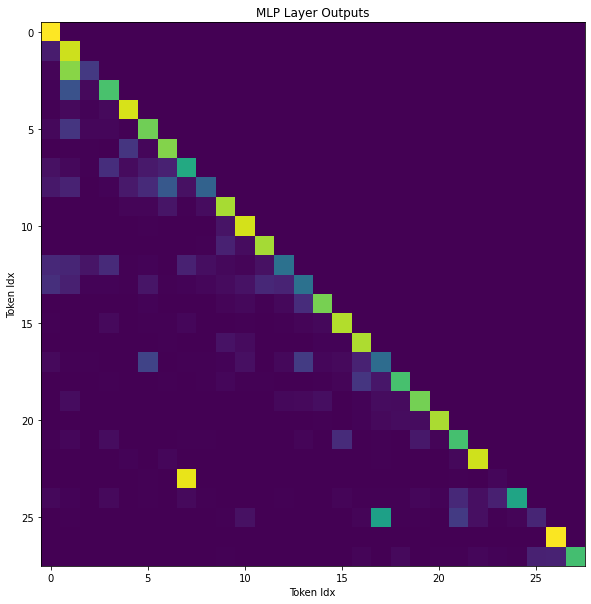

In [130]:
plot_attention(attn_scores[attn_head])

### MLP Analysis

#### Shape of All Components in Transformer Model

In [13]:
print("\n".join([str((k, tinystories_cache[k].shape)) for k in tinystories_cache.keys()]))

('hook_embed', torch.Size([28, 1024]))
('hook_pos_embed', torch.Size([28, 1024]))
('blocks.0.hook_resid_pre', torch.Size([28, 1024]))
('blocks.0.ln1.hook_scale', torch.Size([28, 1]))
('blocks.0.ln1.hook_normalized', torch.Size([28, 1024]))
('blocks.0.attn.hook_q', torch.Size([28, 16, 64]))
('blocks.0.attn.hook_k', torch.Size([28, 16, 64]))
('blocks.0.attn.hook_v', torch.Size([28, 16, 64]))
('blocks.0.attn.hook_attn_scores', torch.Size([16, 28, 28]))
('blocks.0.attn.hook_pattern', torch.Size([16, 28, 28]))
('blocks.0.attn.hook_z', torch.Size([28, 16, 64]))
('blocks.0.hook_attn_out', torch.Size([28, 1024]))
('blocks.0.hook_resid_mid', torch.Size([28, 1024]))
('blocks.0.ln2.hook_scale', torch.Size([28, 1]))
('blocks.0.ln2.hook_normalized', torch.Size([28, 1024]))
('blocks.0.mlp.hook_pre', torch.Size([28, 4096]))
('blocks.0.mlp.hook_post', torch.Size([28, 4096]))
('blocks.0.hook_mlp_out', torch.Size([28, 1024]))
('blocks.0.hook_resid_post', torch.Size([28, 1024]))
('ln_final.hook_scale', t

#### Analyse MLP Values

In [61]:
mlp_out       = tinystories_cache["blocks.0.hook_mlp_out"]
mlp_out_resid = tinystories_cache["blocks.0.hook_resid_post"]
final_out     = tinystories_cache["ln_final.hook_normalized"]

In [62]:
final_out.shape

torch.Size([28, 1024])

In [63]:
final_out

tensor([[-1.7048,  0.0227,  0.2494,  ..., -1.2261,  0.7359, -0.2922],
        [ 0.7746,  1.4525,  1.0352,  ..., -0.8674,  1.3414, -0.0579],
        [ 1.8836, -2.1490,  0.7427,  ..., -0.5858,  1.2664,  0.3775],
        ...,
        [-0.5872,  0.1603,  1.6682,  ...,  1.3413,  2.2046,  0.8557],
        [ 0.3379, -0.0830,  0.6809,  ..., -1.5403,  0.9228, -1.0345],
        [ 2.5006, -3.2701,  0.8509,  ...,  0.9505, -1.1371, -0.5296]])

#### Descriptive Statistics

In [64]:
import torch

def get_stats(mlp_out):
    # Compute statistics
    mean_val = torch.mean(mlp_out)
    std_val = torch.std(mlp_out)
    max_val = torch.max(mlp_out)
    min_val = torch.min(mlp_out)

    # Display the results
    print(f"Mean: {mean_val.item():.4f}")
    print(f"Standard Deviation: {std_val.item():.4f}")
    print(f"Max Value: {max_val.item():.4f}")
    print(f"Min Value: {min_val.item():.4f}")

get_stats(mlp_out)
get_stats(mlp_out_resid)
get_stats(final_out)

Mean: 0.0031
Standard Deviation: 0.7454
Max Value: 55.2631
Min Value: -3.2519
Mean: 0.0027
Standard Deviation: 0.7765
Max Value: 56.2004
Min Value: -3.4359
Mean: -0.0356
Standard Deviation: 1.4738
Max Value: 14.2448
Min Value: -8.6297


#### Visualise MLP Activations

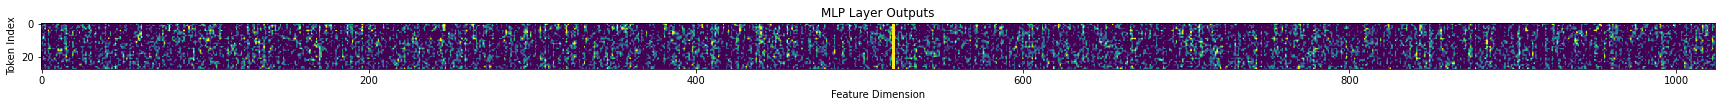

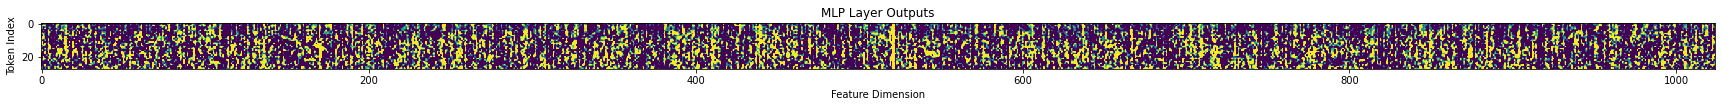

In [108]:
import matplotlib.pyplot as plt
import torch

def plot_activation(mlp_out, width=30, height=10, plot_range=False):
    # Convert the tensor to a numpy array
    mlp_out_np = mlp_out.detach().cpu() # .numpy()
    clipped_mlp_out_np = mlp_out_np.clip(min=-3, max=100)

    # Create a heatmap with larger figure size
    fig, ax = plt.subplots(figsize=(width, height))

    cax = ax.imshow(mlp_out_np, cmap='viridis', vmin=0, vmax=1)  # Set vmin and vmax for color scale

    # Adjust colorbar size and position
    if plot_range:
        cbar = fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Activation Value')

    plt.xlabel('Feature Dimension')
    plt.ylabel('Token Index')
    plt.title('MLP Layer Outputs')
    plt.show()

#plot_activation(mlp_out)
plot_activation(mlp_out_resid)
plot_activation(final_out)

# for i in range(3):
#     plot_activation(mlp_out[i].view(16, 64))

#### Visualise Mean MLP Activations Across Tokens

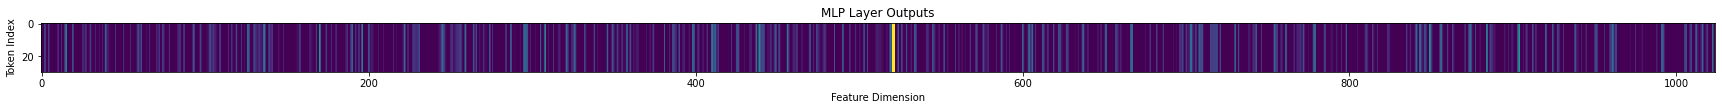

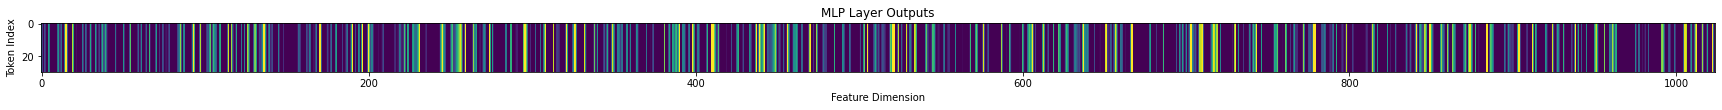

In [111]:
def plot_mean_activation(data):
    data_mean = data.mean(dim=0)
    data_mean = data_mean.view(1, 1024).repeat(30, 1)
    plot_activation(data_mean, width=30, height=30)

plot_mean_activation(mlp_out_resid)
plot_mean_activation(final_out)

#### Visualise StdDev MLP Activations Across Tokens

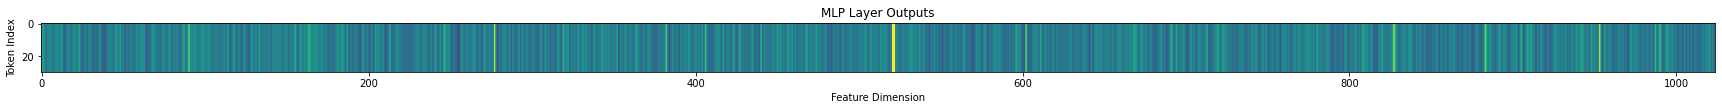

tensor([0.5972, 0.5638, 0.4232,  ..., 0.3931, 0.4462, 0.3669])


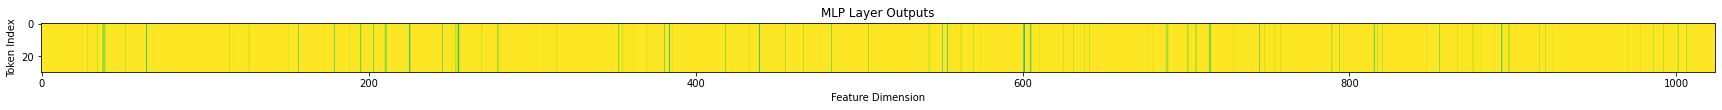

tensor([1.3753, 1.7783, 1.1976,  ..., 1.4169, 1.3790, 1.0237])


In [112]:
def plot_stddev_activation(data):
    data_stddev = data.std(dim=0)
    plot_activation(
        data_stddev.view(1, 1024).repeat(30, 1), width=30, height=30, plot_range=False)
    print(data_stddev)
plot_stddev_activation(mlp_out_resid)
plot_stddev_activation(final_out)